<a href="https://colab.research.google.com/github/0-lingual/Advanced-machine-learning/blob/main/Tutorial_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning Tutorial


In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# This mounts your google drive storage to this code
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

root = '/content/gdrive/My Drive/Test/'


Using cuda device


First, Let's classify "STL10" dataset **without** transfer learning

In [3]:
# DATA LOAD (STL10 Dataset)

# settings for data normalization
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    # transforms.Resize((96,96))
])


train_data = datasets.STL10(
    root=root,
    split='train',
    download=True,
    transform=transform)

test_data = datasets.STL10(
    root=root,
    split='test',
    download=True,
    transform=transform)


batch_size = 32
train_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data,batch_size=batch_size,shuffle=False)


classes = ('airplane', 'bird', 'car', 'cat',
           'deer', 'dog', 'horse', 'monkey', 'ship', 'truck')


print('Training Data:', len(train_data), 'Test Data', len(test_data))

100%|██████████| 2640397119/2640397119 [02:23<00:00, 18463621.19it/s]


Extracting /content/gdrive/My Drive/Test/stl10_binary.tar.gz to /content/gdrive/My Drive/Test/
Files already downloaded and verified
Training Data: 5000 Test Data 8000


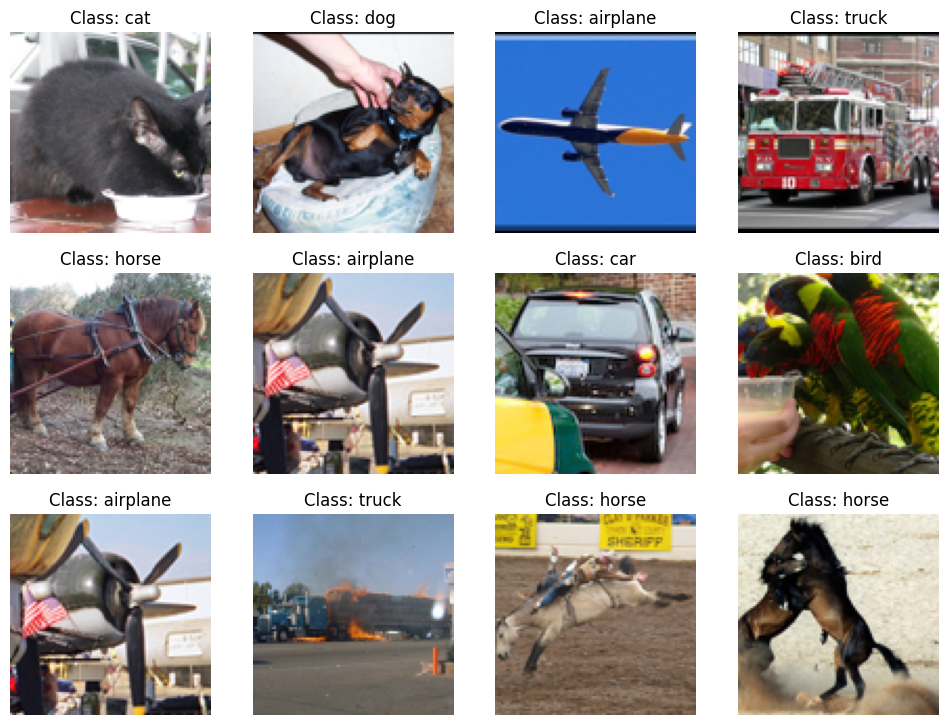

In [4]:
# visualize some data
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


images, labels = next(iter(train_loader))



sample_index = np.random.choice(batch_size, size=12)     # take 12 random sample index
num_samples = sample_index.size

random_samples = images[sample_index].cpu().numpy()

plt.figure(figsize=(12, 12))

# display test samples
for k in range(num_samples):
    plt.subplot(4, 4, k + 1)
    plt.imshow(random_samples[k].reshape(3,96, 96).transpose(1,2,0)/2 + 0.5)
    plt.title("Class: " + str( classes[labels[sample_index[k]].item()])  )
    plt.axis('off')


plt.show()

In [5]:
# define the CNN:
# two convolution layers followed by two linear layers

class MyConvNet(nn.Module):   # nn.Module should be inherited for the neural network configuration so that it can work with backpropagation APIs
    def __init__(self):    # define layers: two conv layers and two linear (fully connected) layers
        super(MyConvNet, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, 5),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32, 64, 5),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Flatten(),
            nn.Linear(21*21*64, 512),
            nn.Linear(512, 10)
        )

        # weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight.data)      # He normalization

    # network connection: two conv layers, each followed by relu and max-pooling with (2x2) kernel, and two linear layer
    def forward(self, x):
        logits = self.conv_layers(x)
        return(logits)


# generate neural net model
model = MyConvNet().to(device)
print(model)


MyConvNet(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=28224, out_features=512, bias=True)
    (8): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [6]:
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

criterion = nn.CrossEntropyLoss()

In [7]:
# training and test

# epoch: 10
# data dimension: batch_size x Channels x Height x Width (NCHW)
for epoch in range(10):
    # training phase
    # model.train()
    current_loss= 0.0
    for batch_num, (x, target) in enumerate(train_loader):
        x, target = x.to(device), target.to(device)

        out = model(x)
        loss = criterion(out,target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        current_loss += loss

        # display the training loss in every 100 batches
        if (batch_num+1)%100 == 0 or (batch_num+1)%100 == len(train_loader):
            print('epoch: %d, batch_num: %d, current_loss: %.3f' %(epoch, batch_num+1, current_loss/100))
            current_loss = 0.0


    # test phase
    with torch.no_grad():
        # model.eval()
        total_samples = 0.0
        correct_samples = 0.0
        for (x, target) in test_loader:
            x, target = x.to(device), target.to(device)
            out = model(x)
            pred = torch.argmax(out,1)
            correct_samples += (pred == target).sum()
        print('Accuracy: %.3f' %(100*float(correct_samples) / float(len(test_data))))




epoch: 0, batch_num: 100, current_loss: 5.157
Accuracy: 10.012
epoch: 1, batch_num: 100, current_loss: 2.304
Accuracy: 9.988
epoch: 2, batch_num: 100, current_loss: 2.304
Accuracy: 10.000
epoch: 3, batch_num: 100, current_loss: 2.304
Accuracy: 10.000
epoch: 4, batch_num: 100, current_loss: 2.305
Accuracy: 13.037
epoch: 5, batch_num: 100, current_loss: 2.303
Accuracy: 10.225
epoch: 6, batch_num: 100, current_loss: 2.237
Accuracy: 26.425
epoch: 7, batch_num: 100, current_loss: 1.984
Accuracy: 24.113
epoch: 8, batch_num: 100, current_loss: 1.821
Accuracy: 29.512
epoch: 9, batch_num: 100, current_loss: 1.672
Accuracy: 30.288


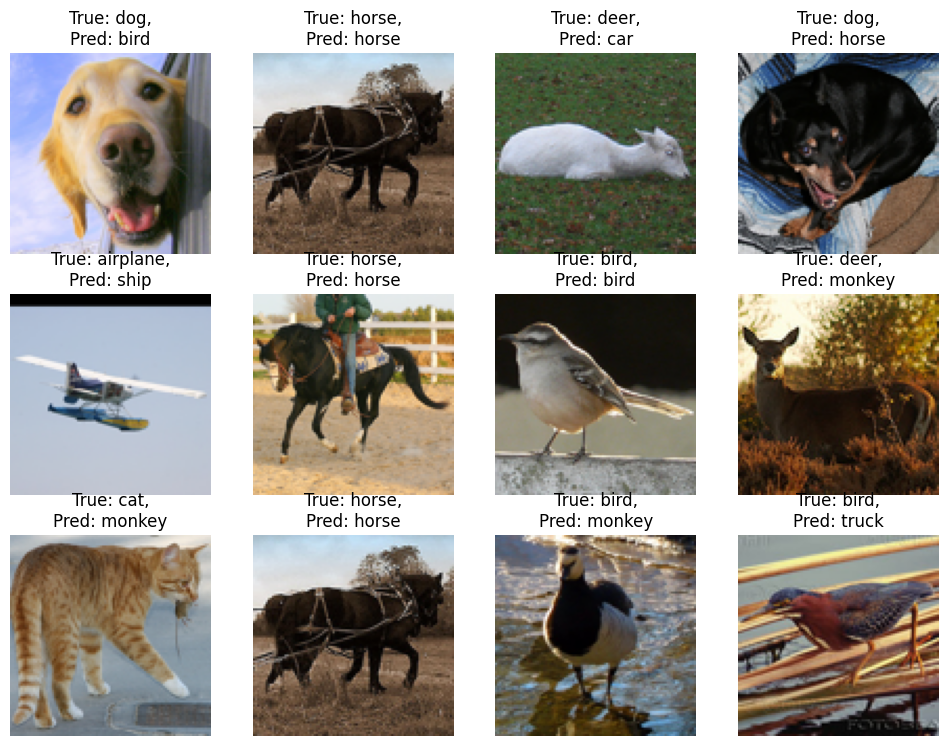

In [8]:
# Display Some test results
import numpy as np
import matplotlib.pyplot as plt


# take one batch of the data
test_data, test_labels = next(iter(test_loader))

# if cuda_available:
test_data, test_labels = test_data.to(device), test_labels.to(device)
out = model(test_data)              # put the test data to the trained network
pred = torch.argmax(out,1)          # prediction to the highest probability


sample_index = np.random.choice(batch_size, size=12)     # take 12 random sample index
num_samples = sample_index.size

random_samples = test_data[sample_index].cpu().numpy()

plt.figure(figsize=(12, 12))

# display test samples
for k in range(num_samples):
    plt.subplot(4, 4, k + 1)
    plt.imshow(random_samples[k].reshape(3,96, 96).transpose(1,2,0)/2 + 0.5)
    plt.title("True: " + str( classes[test_labels[sample_index[k]].item()]) + ",\nPred: " + str(classes[pred[sample_index[k]].item()]))
    plt.axis('off')


plt.show()

# Now, Let's try **Transfer Learning**

1. Pre-train the network with cifar-10 dataset
2. fine-tune with STL10 dataset

In [9]:
# DATA LOAD (cifar-10 dataset)

# settings for data normalization
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Resize((96,96))
])


train_data = datasets.CIFAR10(
    root=root,
    train=True,
    download=True,
    transform=transform)

test_data = datasets.CIFAR10(
    root=root,
    train=False,
    download=True,
    transform=transform)


batch_size = 32
train_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data,batch_size=batch_size,shuffle=False)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print('Training Data:', len(train_data), 'Test Data', len(test_data))

100%|██████████| 170498071/170498071 [00:01<00:00, 91779986.12it/s]


Extracting /content/gdrive/My Drive/Test/cifar-10-python.tar.gz to /content/gdrive/My Drive/Test/
Files already downloaded and verified
Training Data: 50000 Test Data 10000


In [10]:
# generate neural net model
model = MyConvNet().to(device)
print(model)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Loss Function
criterion = nn.CrossEntropyLoss()

MyConvNet(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=28224, out_features=512, bias=True)
    (8): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [11]:
# training and test

# epoch: 5
# data dimension: batch_size x Channels x Height x Width (NCHW)
for epoch in range(5):
    # training phase
    # model.train()
    current_loss= 0.0
    for batch_num, (x, target) in enumerate(train_loader):
        x, target = x.to(device), target.to(device)

        out = model(x)
        loss = criterion(out,target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        current_loss += loss

        # display the training loss in every 100 batches
        if (batch_num+1)%100 == 0 or (batch_num+1)%100 == len(train_loader):
            print('epoch: %d, batch_num: %d, current_loss: %.3f' %(epoch, batch_num+1, current_loss/100))
            current_loss = 0.0


    # test phase
    with torch.no_grad():
        # model.eval()
        total_samples = 0.0
        correct_samples = 0.0
        for (x, target) in test_loader:
            x, target = x.to(device), target.to(device)
            out = model(x)
            pred = torch.argmax(out,1)
            correct_samples += (pred == target).sum()
        print('Accuracy: %.3f' %(100*float(correct_samples) / float(len(test_data))))




epoch: 0, batch_num: 100, current_loss: 3.793
epoch: 0, batch_num: 200, current_loss: 2.168
epoch: 0, batch_num: 300, current_loss: 2.089
epoch: 0, batch_num: 400, current_loss: 2.057
epoch: 0, batch_num: 500, current_loss: 2.029
epoch: 0, batch_num: 600, current_loss: 1.967
epoch: 0, batch_num: 700, current_loss: 1.957
epoch: 0, batch_num: 800, current_loss: 1.943
epoch: 0, batch_num: 900, current_loss: 1.846
epoch: 0, batch_num: 1000, current_loss: 1.808
epoch: 0, batch_num: 1100, current_loss: 1.686
epoch: 0, batch_num: 1200, current_loss: 1.684
epoch: 0, batch_num: 1300, current_loss: 1.674
epoch: 0, batch_num: 1400, current_loss: 1.596
epoch: 0, batch_num: 1500, current_loss: 1.620
Accuracy: 41.270
epoch: 1, batch_num: 100, current_loss: 1.457
epoch: 1, batch_num: 200, current_loss: 1.464
epoch: 1, batch_num: 300, current_loss: 1.432
epoch: 1, batch_num: 400, current_loss: 1.411
epoch: 1, batch_num: 500, current_loss: 1.378
epoch: 1, batch_num: 600, current_loss: 1.383
epoch: 1, b

Pre-training is done!

Now, Let's fine-tune with STL10 dataset

In [12]:
print(model)

MyConvNet(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=28224, out_features=512, bias=True)
    (8): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [13]:
# Replace the last few layers


# # model.conv_layers[7] = nn.Linear(21*21*64, 128).to(device)
model.conv_layers[8] = nn.Linear(512, 10).to(device)       # Replace Last layer


In [14]:
# Load STL10 data again

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    # transforms.Resize((96,96))
])

train_data = datasets.STL10(
    root=root,
    split='train',
    download=True,
    transform=transform)

test_data = datasets.STL10(
    root=root,
    split='test',
    download=True,
    transform=transform)


batch_size = 32
train_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data,batch_size=batch_size,shuffle=False)


classes = ('airplane', 'bird', 'car', 'cat',
           'deer', 'dog', 'horse', 'monkey', 'ship', 'truck')



Files already downloaded and verified
Files already downloaded and verified


In [15]:
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Loss Function
criterion = nn.CrossEntropyLoss()

In [16]:
# training and test

# epoch: 5
# data dimension: batch_size x Channels x Height x Width (NCHW)
for epoch in range(5):
    # training phase
    # model.train()
    current_loss= 0.0
    for batch_num, (x, target) in enumerate(train_loader):
        x, target = x.to(device), target.to(device)

        out = model(x)
        loss = criterion(out,target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        current_loss += loss

        # display the training loss in every 100 batches
        if (batch_num+1)%100 == 0 or (batch_num+1)%100 == len(train_loader):
            print('epoch: %d, batch_num: %d, current_loss: %.3f' %(epoch, batch_num+1, current_loss/100))
            current_loss = 0.0


    # test phase
    with torch.no_grad():
        # model.eval()
        total_samples = 0.0
        correct_samples = 0.0
        for (x, target) in test_loader:
            x, target = x.to(device), target.to(device)
            out = model(x)
            pred = torch.argmax(out,1)
            correct_samples += (pred == target).sum()
        print('Accuracy: %.3f' %(100*float(correct_samples) / float(len(test_data))))




epoch: 0, batch_num: 100, current_loss: 2.048
Accuracy: 48.337
epoch: 1, batch_num: 100, current_loss: 1.099
Accuracy: 55.850
epoch: 2, batch_num: 100, current_loss: 0.654
Accuracy: 58.862
epoch: 3, batch_num: 100, current_loss: 0.333
Accuracy: 60.188
epoch: 4, batch_num: 100, current_loss: 0.156
Accuracy: 60.175
